# Evironment initialization

In [6]:
source("./initialization.r")

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: DT
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: magick
Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading re

# Data inspection

In [7]:
bugsData <- read.table("bugs.csv", header=TRUE, sep=";", stringsAsFactors=FALSE)

In [4]:
classes <- sapply(bugsData, class)
classes
dim(bugsData)
dim(na.omit(bugsData))

CBO                 DIT               FanIn              FanOut 
          "integer"           "integer"           "integer"           "integer" 
               LCOM                 NOC                 RFC                 WMC 
          "integer"           "integer"           "integer"           "integer" 
                LOC          Attributes AttributesInherited             Methods 
          "integer"           "integer"           "integer"           "integer" 
   MethodsInherited                Bugs 
          "integer"           "integer"

[1] 997  14

[1] 997  14

In [5]:
summary(bugsData)

      CBO              DIT            FanIn             FanOut      
 Min.   :  0.00   Min.   :1.000   Min.   :  0.000   Min.   : 0.000  
 1st Qu.:  3.00   1st Qu.:1.000   1st Qu.:  1.000   1st Qu.: 2.000  
 Median :  7.00   Median :2.000   Median :  2.000   Median : 4.000  
 Mean   : 12.22   Mean   :2.727   Mean   :  5.368   Mean   : 7.395  
 3rd Qu.: 14.00   3rd Qu.:4.000   3rd Qu.:  4.000   3rd Qu.:10.000  
 Max.   :156.00   Max.   :8.000   Max.   :137.000   Max.   :93.000  
      LCOM              NOC               RFC               WMC         
 Min.   :    0.0   Min.   : 0.0000   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:    6.0   1st Qu.: 0.0000   1st Qu.:  12.00   1st Qu.:   8.00  
 Median :   28.0   Median : 0.0000   Median :  30.00   Median :  20.00  
 Mean   :  364.7   Mean   : 0.7121   Mean   :  76.87   Mean   :  58.38  
 3rd Qu.:   91.0   3rd Qu.: 0.0000   3rd Qu.:  70.00   3rd Qu.:  50.00  
 Max.   :81003.0   Max.   :26.0000   Max.   :2603.00   Max.   :1680.00  
      

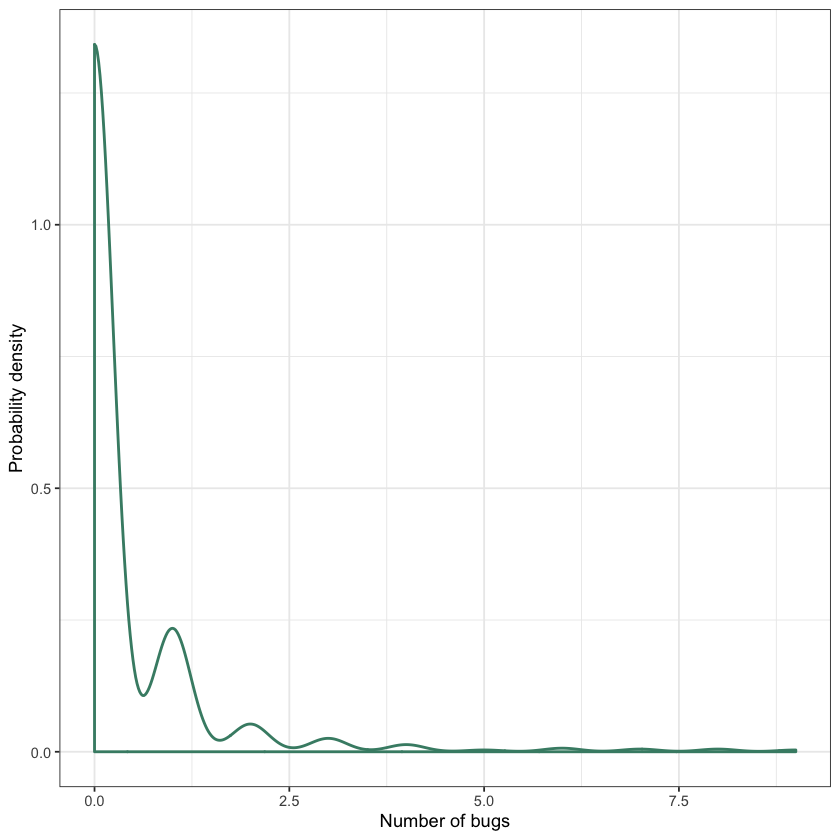

In [6]:
 ggplot(data=bugsData, aes(x=Bugs)) +
  geom_density(color = "aquamarine4", lwd = 0.8) +
  labs(x = "Number of bugs", y = "Probability density") +
  theme_bw()

# Statistical analysis
Correletion "matrix"

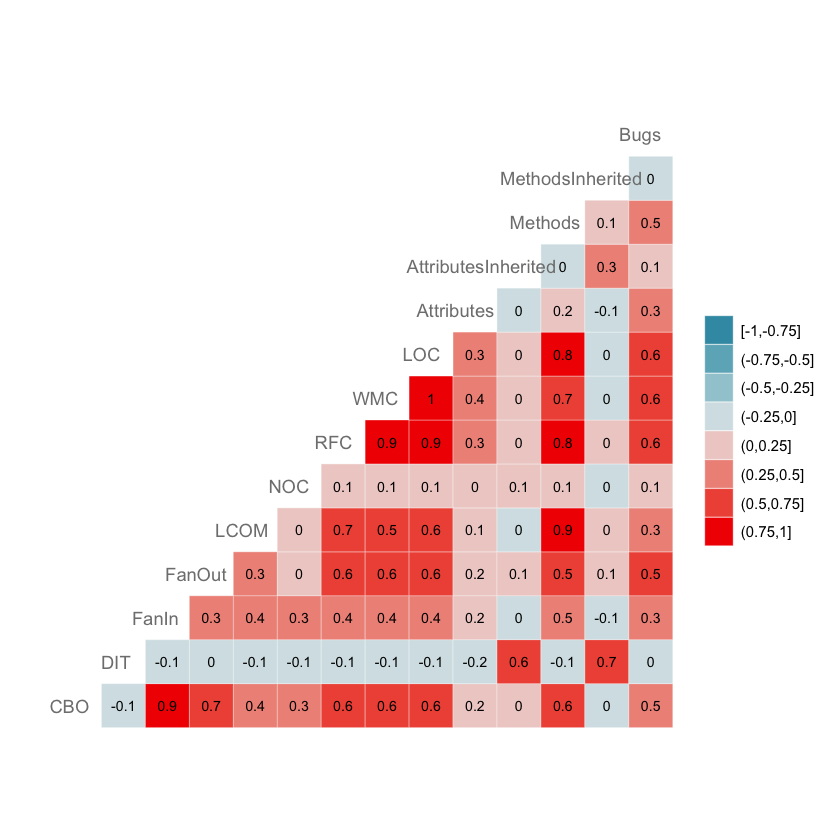

In [7]:
ggcorr(
    bugsData,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

## Data distribution plotted
Don't know how to interpret this...

In [9]:
numericChart <- function(colName, colorCol) {
  ggplot(bugsData, aes(x = Bugs, y = bugsData[[colName]])) +
    geom_jitter(size = 1.5, stat = "identity", colour=colorCol) +
    labs(x = "Bugs", y = colName) +
    theme_bw()
}

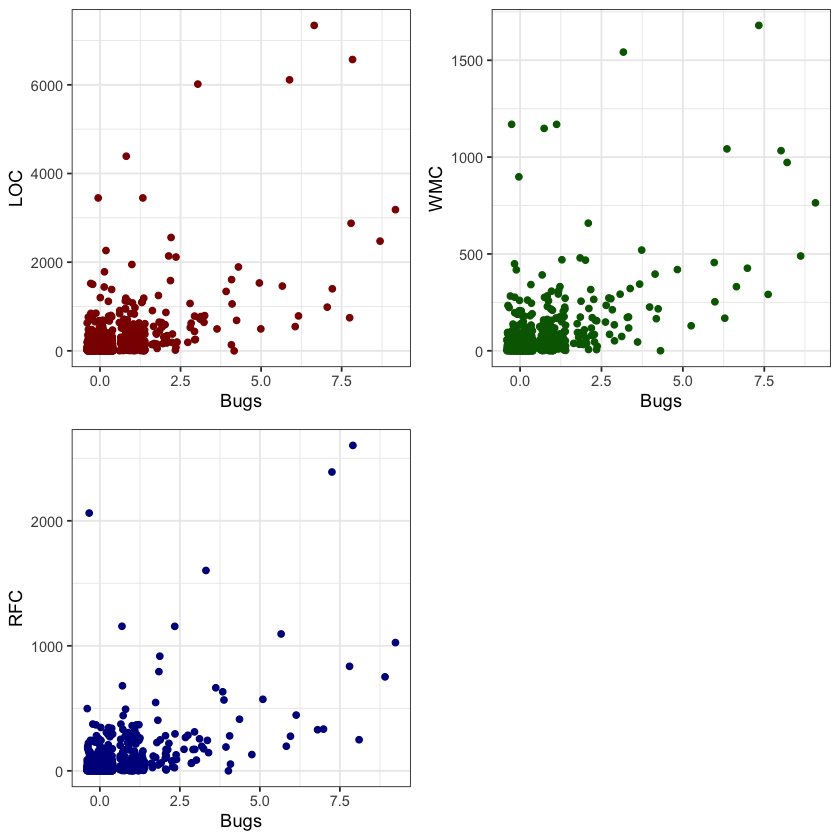

In [10]:
plot_grid(
  numericChart("LOC", "darkred"),
  numericChart("WMC", "darkgreen"),
  numericChart("RFC", "darkblue")
)

# Prepare prediction environment

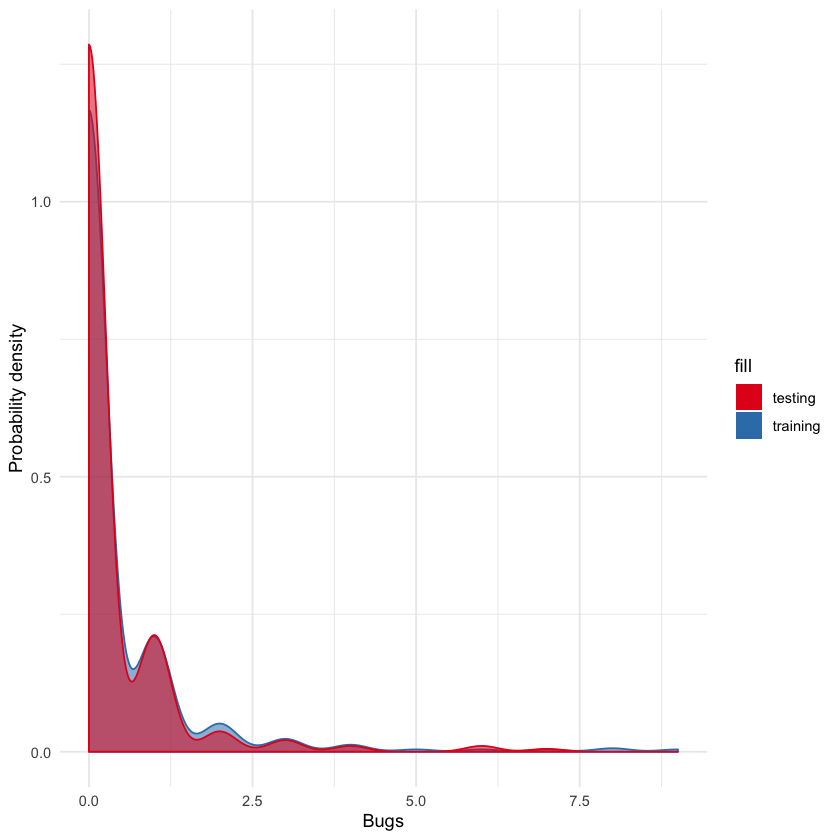

In [11]:
inTrain <- createDataPartition(bugsData$Bugs, p=0.7, list=FALSE)
training <- bugsData[inTrain,]
testing <- bugsData[-inTrain,]

ggplot(mapping=aes(alpha=0.2)) + 
 geom_density(aes(Bugs, fill="training", color="training"), training) + 
 geom_density(aes(Bugs, fill="testing", color="testing"), testing) + 
 theme_minimal() +
  xlab("Bugs") +
  ylab("Probability density") +
  scale_fill_brewer(palette="Set1") +
  scale_color_brewer(palette="Set1") + 
  guides(color = FALSE, alpha = FALSE, fill=guide_legend(override.aes = list(color = NA)))

In [12]:
X_train = select(training, -Bugs)
y_train = training$Bugs
X_test = select(testing, -Bugs)
y_test = testing$Bugs

In [13]:
trcontrol = trainControl(
  method = "cv",
  number = 10,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

In [14]:
evaluateStats <- function(model) {
  predicted = predict(model, X_test)
  residuals = y_test - predicted
  
  RMSE <- round(sqrt(mean(residuals^2)), 3)
  
  y_testMean = mean(y_test)
  totalSS =  sum((y_test - y_testMean)^2 )
  residualSS =  sum(residuals^2)
  rSquare  =  round(1 - (residualSS/totalSS), 3)
  
  list(RMSE = RMSE, rSquare = rSquare)
}

In [15]:
predictionChart <- function(model) {
  predicted = predict(model, X_test)
  mergedResults = as.data.frame(cbind(predicted = predicted, observed = y_test))
  # Plot predictions vs test data
  ggplot(mergedResults, aes(y = predicted, x = observed)) +
    geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm) +
    ylab("Predicted number of bugs") +
    xlab("Real number of bugs") + 
    theme(
      axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
      axis.title.x = element_text(size=14), axis.title.y = element_text(size=14)
    )
}

In [16]:
importancePlot <- function(model) ggplot(varImp(model))

# kNN without Preprocessing

In [16]:
knnGrid <- expand.grid(k = seq(1, 25, by = 2))

In [17]:
knnModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid
)

In [18]:
knnModel

k-Nearest Neighbors 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 629, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.9601611  0.3150079  0.3931884
   3  0.8829554  0.3604143  0.3837819
   5  0.8795946  0.3759584  0.3988875
   7  0.8793489  0.3814459  0.4014947
   9  0.8783016  0.3792925  0.4049413
  11  0.8631682  0.3923290  0.4029466
  13  0.8624331  0.3964993  0.4049752
  15  0.8643656  0.3905176  0.4042965
  17  0.8566519  0.4009172  0.4010665
  19  0.8588850  0.3986943  0.4007061
  21  0.8576121  0.4076358  0.3990857
  23  0.8658259  0.3971095  0.4027625
  25  0.8704266  0.3921622  0.4056561

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 17.

In [19]:
knnModel$bestTune
knnStats <- evaluateStats(knnModel)
knnStats

,k
,<dbl>
9,17


$RMSE
[1] 0.726

$rSquare
[1] 0.31

##### knnStats <- evaluateStats(knnModel)
knnStats

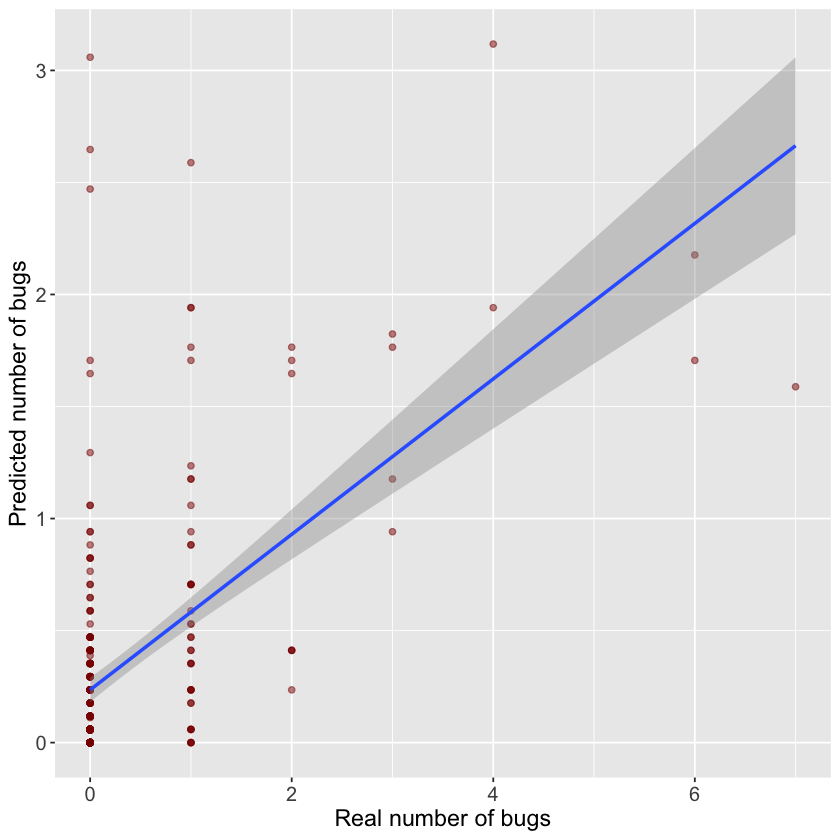

In [20]:
predictionChart(knnModel)

# kNN with Preprocessing

In [21]:
knnPreModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid,
  preProcess = c("center", "scale")
)

In [22]:
knnPreModel

k-Nearest Neighbors 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  1.1110315  0.2337919  0.4312629
   3  0.9897522  0.2479433  0.4126622
   5  0.9182531  0.3010976  0.3985362
   7  0.8735214  0.3574528  0.3860900
   9  0.8546614  0.3764351  0.3887466
  11  0.8465719  0.3857048  0.3876368
  13  0.8512078  0.3906381  0.3905497
  15  0.8543840  0.3926405  0.3925642
  17  0.8631234  0.3868694  0.3960383
  19  0.8671264  0.3810937  0.3985816
  21  0.8715443  0.3816981  0.4002719
  23  0.8787554  0.3749737  0.4020283
  25  0.8866052  0.3672288  0.4043527

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 11.

In [23]:
knnPreModel$bestTune

,k
,<dbl>
6,11


In [24]:
knnPreStats <- evaluateStats(knnPreModel)
knnPreStats

$RMSE
[1] 0.746

$rSquare
[1] 0.271

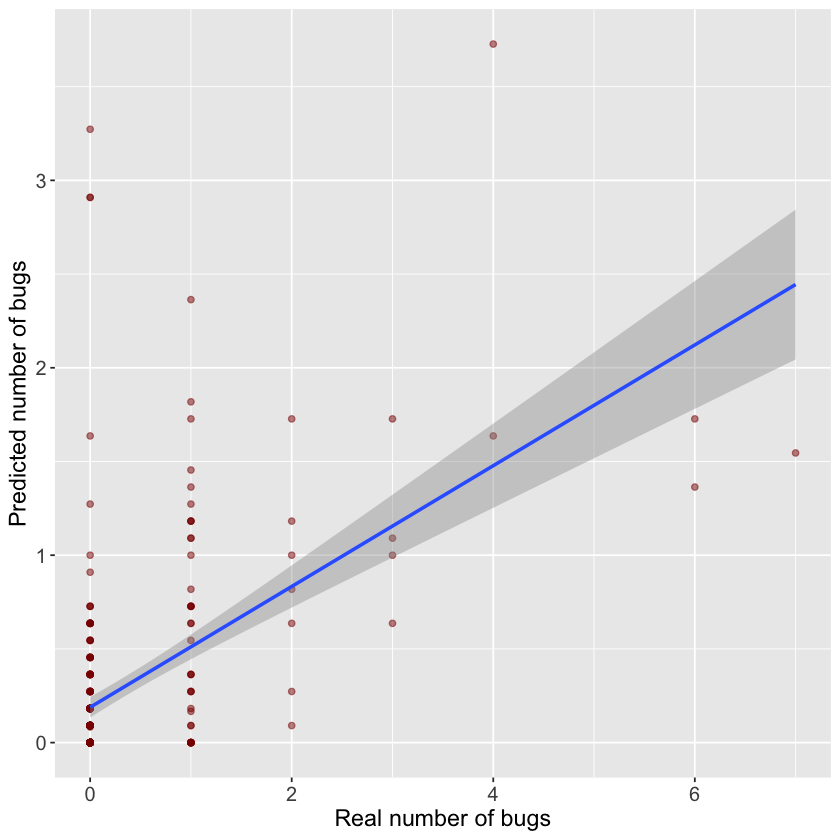

In [25]:
predictionChart(knnPreModel)

# Random Forest Regression

In [26]:
rfGrid <- expand.grid(.mtry=ncol(X_train)/3)

In [27]:
rfModel <- train(
  X_train, y_train,
  method = "rf",
  trControl = trcontrol,
  tuneGrid = rfGrid,
  importance = TRUE
)

In [28]:
rfModel

Random Forest 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 629, 628, 629, 628, 628, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8595395  0.4261077  0.4208862

Tuning parameter 'mtry' was held constant at a value of 4.333333

In [29]:
rfModel$bestTune

mtry
<dbl>
4.333333


In [30]:
rfStats <- evaluateStats(rfModel)
rfStats

$RMSE
[1] 0.752

$rSquare
[1] 0.259

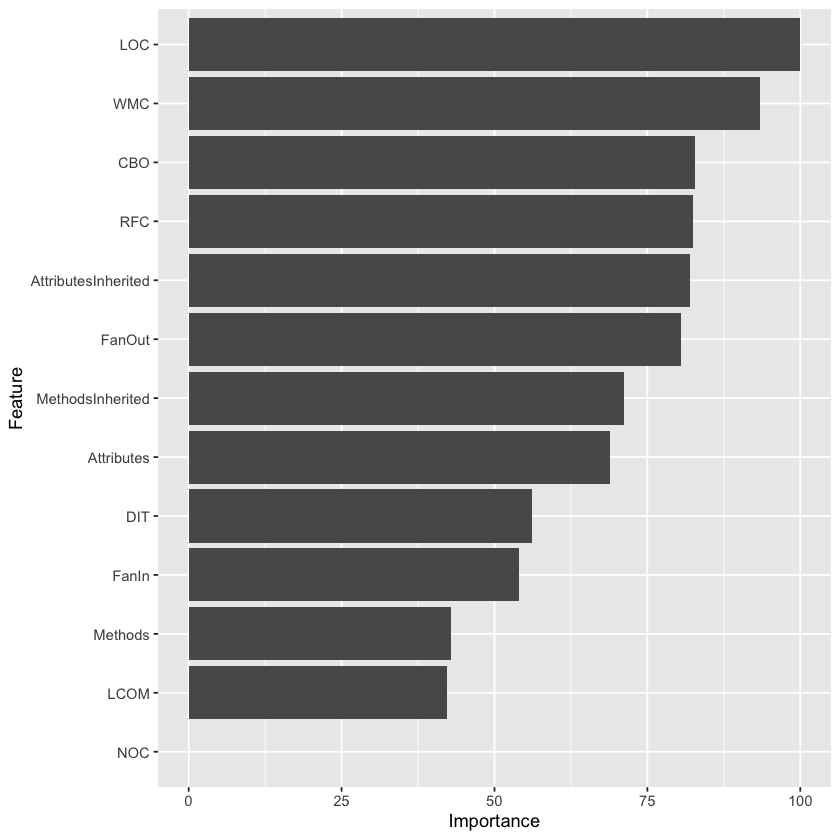

In [31]:
importancePlot(rfModel)

# Extreme Gradient Boosting regression

In [32]:
xgbGrid <- expand.grid(
    nrounds = c(100,200), 
    max_depth = c(10, 15, 20, 25),
    colsample_bytree = seq(0.5, 0.9, length.out = 5),
    eta = 0.1,
    gamma=0,
    min_child_weight = 1,
    subsample = 1
  )

In [33]:
xgbModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)

In [36]:
xgbModel

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8898867  0.3775024  0.4270575
  10         0.5               200      0.8905914  0.3769755  0.4278259
  10         0.6               100      0.8969452  0.3681897  0.4221017
  10         0.6               200      0.8971113  0.3684032  0.4223535
  10         0.7               100      0.9124844  0.3503759  0.4244964
  10         0.7               200      0.9129505  0.3500249  0.4247938
  10         0.8               100      0.9181521  0.3512107  0.4213564
  10         0.8               200      0.9185492  0.3512472  0.4217109
  10         0.9               100      0.9520986  0.3204612  0.4284822
  10         0.9               200      0.9522027  0.3207756  0.4284628
  15         0.5 

In [37]:
xgbModel$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,100,20,0.1,0,0.5,1,1


In [38]:
xgbStats <- evaluateStats(xgbModel)
xgbStats

$RMSE
[1] 0.798

$rSquare
[1] 0.165

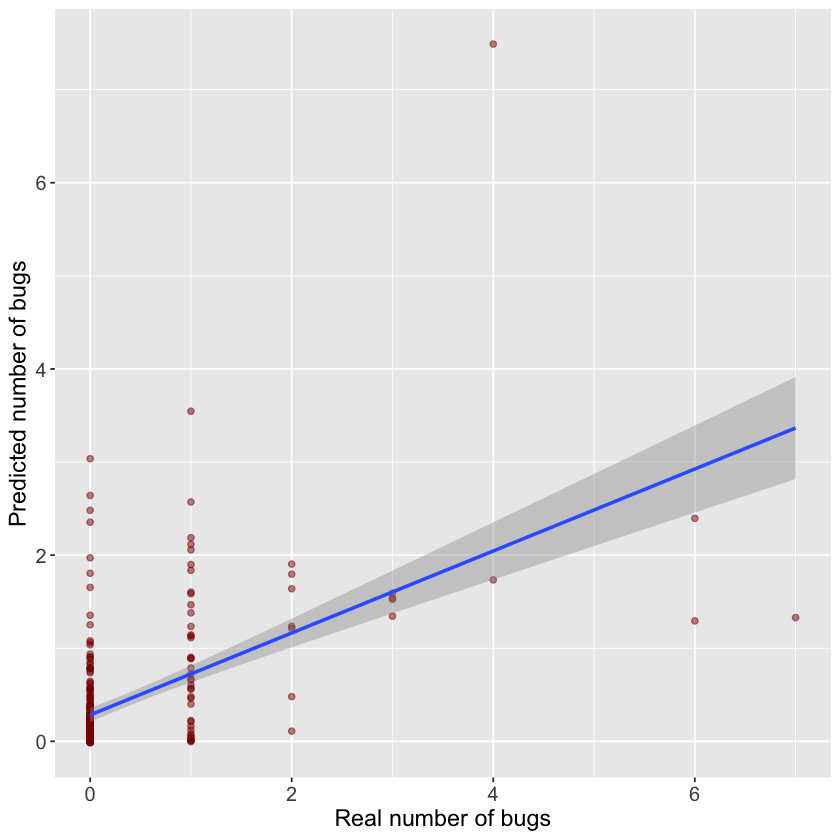

In [39]:
predictionChart(xgbModel)

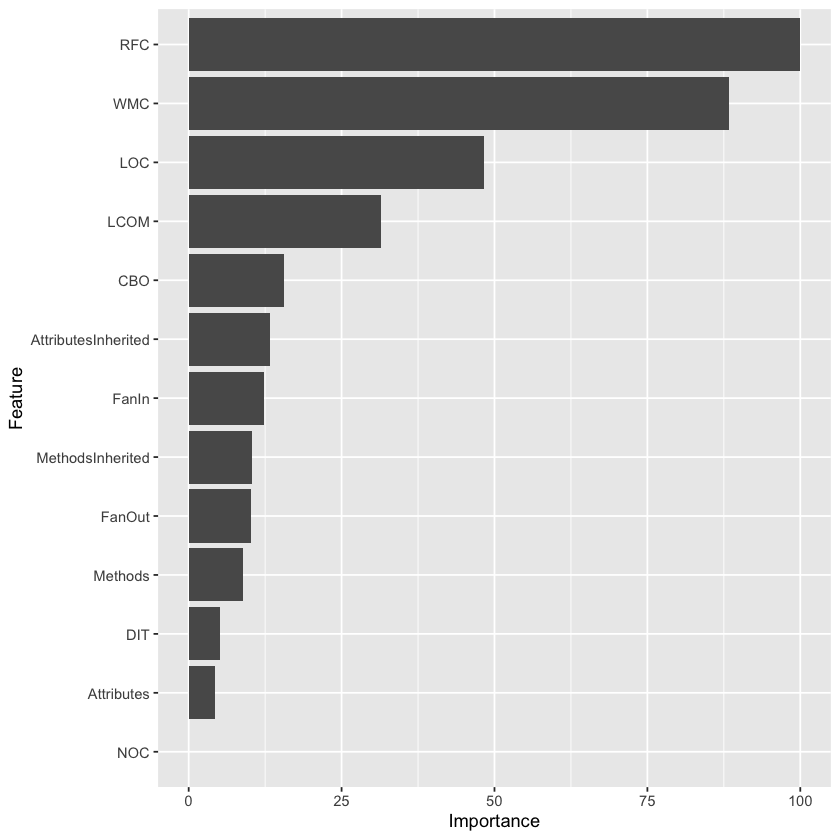

In [40]:
importancePlot(xgbModel)

In [41]:
xgbPreModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree",
  preProcess = c("center", "scale")
)

In [42]:
xgbPreModel

eXtreme Gradient Boosting 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8377464  0.4242739  0.4046140
  10         0.5               200      0.8381507  0.4242313  0.4049667
  10         0.6               100      0.8793881  0.3774892  0.4175277
  10         0.6               200      0.8796041  0.3775956  0.4175385
  10         0.7               100      0.8891448  0.3679789  0.4166799
  10         0.7               200      0.8894802  0.3680964  0.4169136
  10         0.8               100      0.9466178  0.3496045  0.4249864
  10         0.8               200      0.9470641  0.3499382  0.4254958
  10         0.9               100      0.9364910  0.3302226  0.4309303
  10         0.9               200      0.9367627  0.3307362  0

In [43]:
xgbPreModel$bestTune

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,10,0.1,0,0.5,1,1


In [44]:
xgbPreStats <- evaluateStats(xgbPreModel)
xgbPreStats

$RMSE
[1] 0.796

$rSquare
[1] 0.169

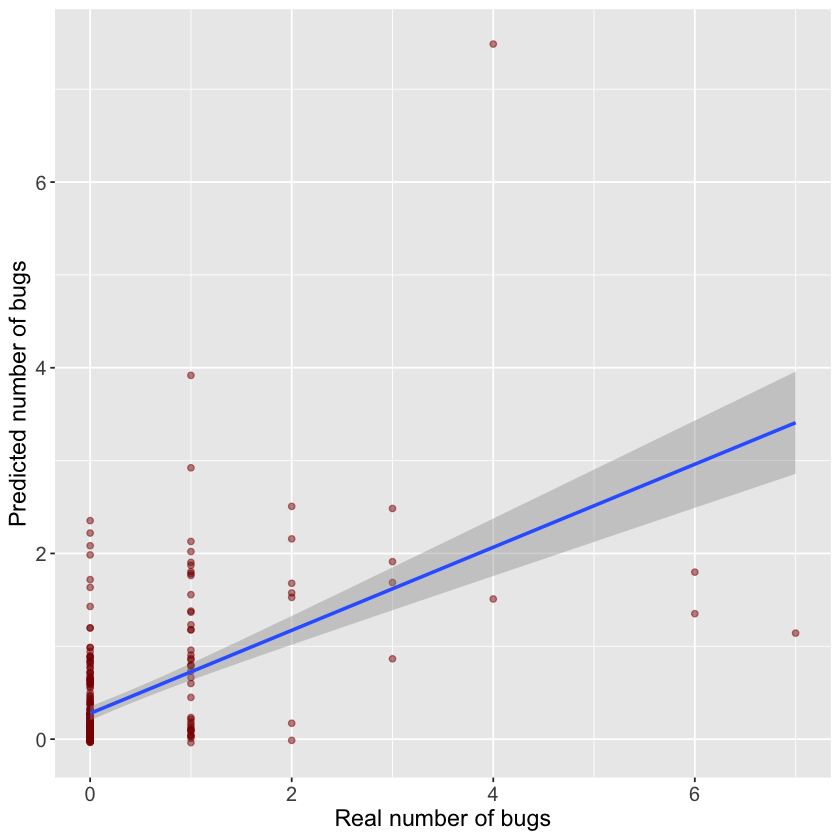

In [45]:
predictionChart(xgbPreModel)

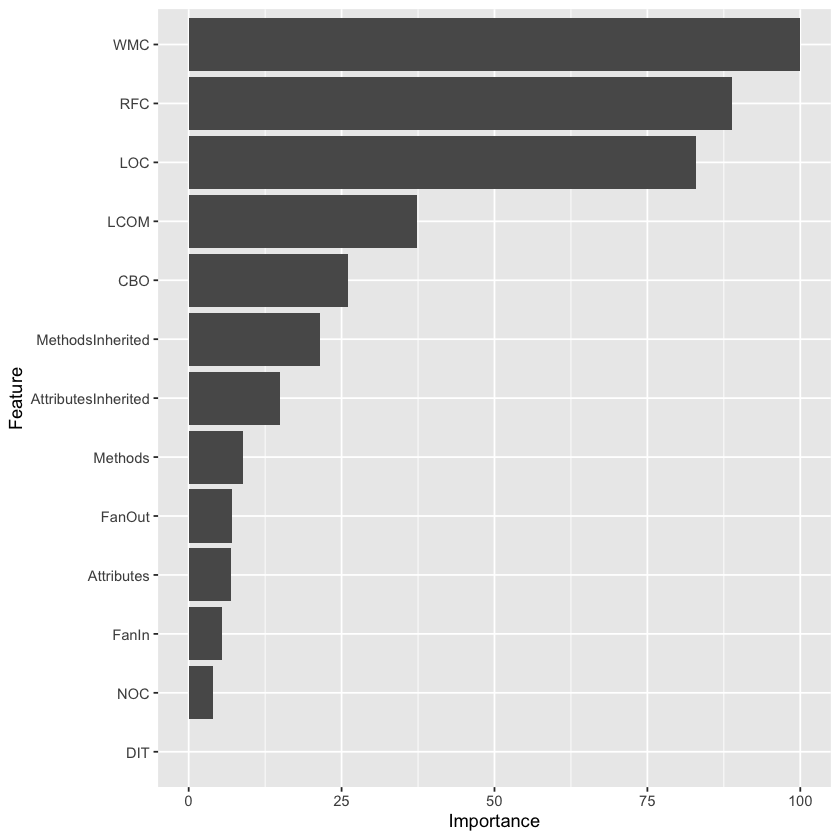

In [46]:
importancePlot(xgbPreModel)

# Neural Net predition using 'caret' library

In [47]:
nnetGrid <-  expand.grid(size = seq(from = 1, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 0.5, by = 0.1))

In [1]:
nnetModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid= nnetGrid,
  method = "nnet",
  preProcess = c("center", "scale")
)

ERROR: Error in train(X_train, y_train, trControl = trcontrol, tuneGrid = nnetGrid, : nie udało się znaleźć funkcji 'train'


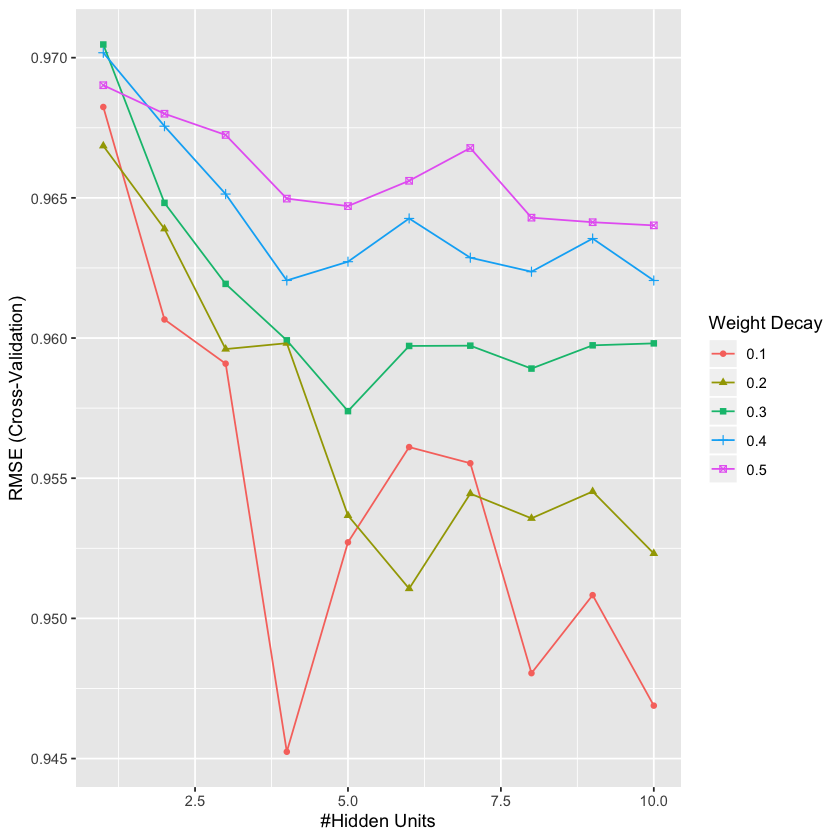

In [57]:
ggplot(nnetModel)

In [52]:
nnetModel$bestTune

,size,decay
,<dbl>,<dbl>
16,4,0.1


In [53]:
nnetModelStats <- evaluateStats(nnetModel)
nnetModelStats

$RMSE
[1] 0.752

$rSquare
[1] 0.258

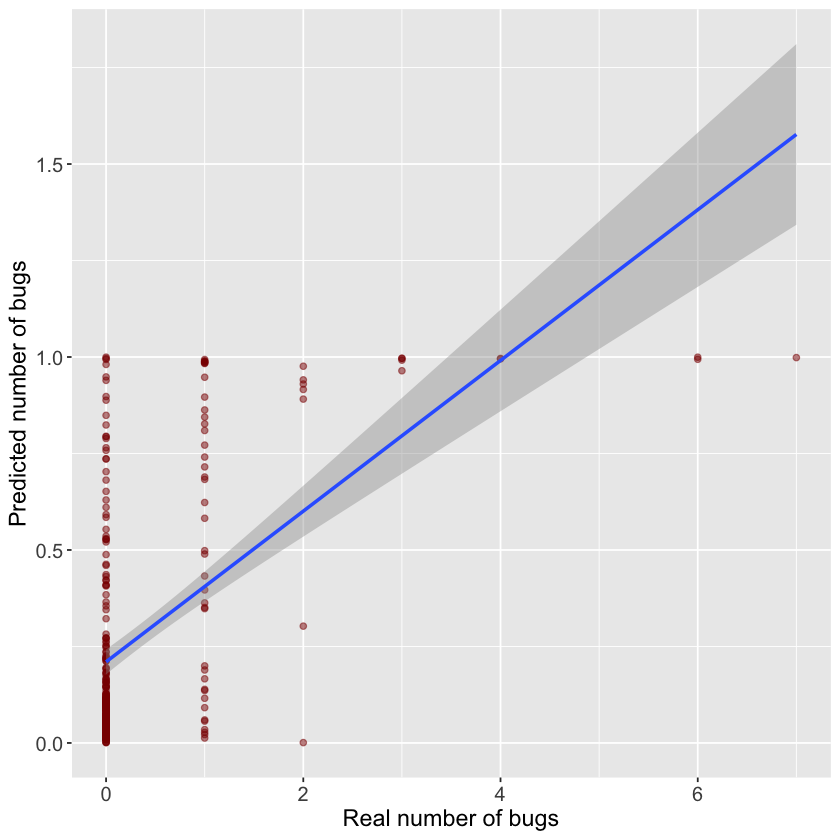

In [54]:
predictionChart(nnetModel)

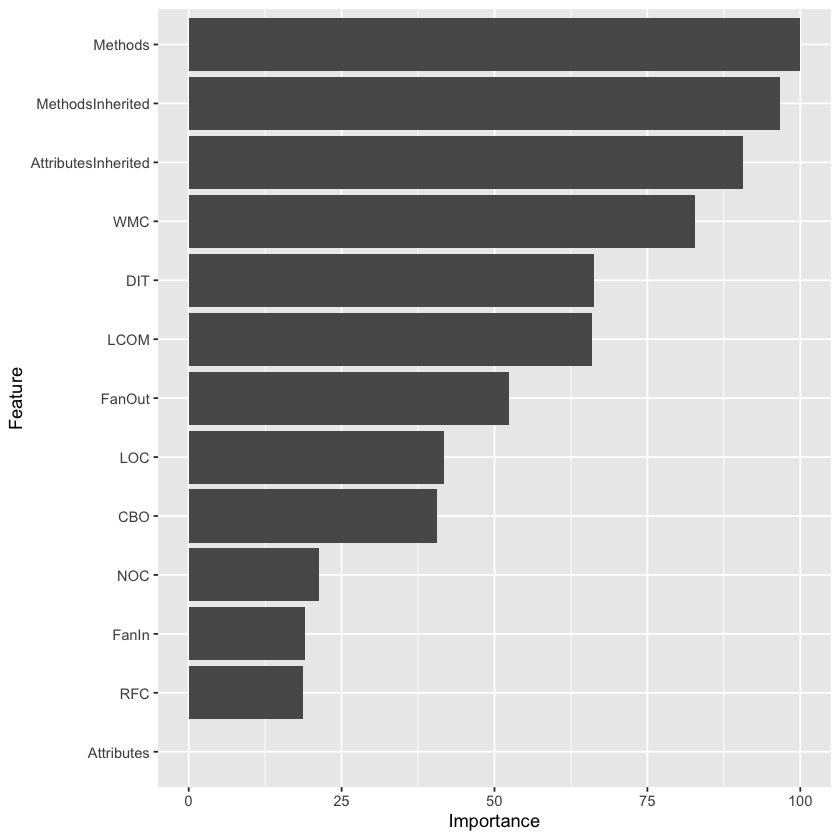

In [56]:
importancePlot(nnetModel)

# Neural Net predition using 'neuralnet' library

In [17]:
maxs <- apply(bugsData, 2, max) 
mins <- apply(bugsData, 2, min)
scaled <- as.data.frame(scale(bugsData, center = mins, scale = maxs - mins))
train_ <- scaled[inTrain,]
test_ <- scaled[-inTrain,]

In [18]:
n <- names(train_)
formula <- as.formula(paste("Bugs ~", paste(n[!n %in% "Bugs"], collapse = " + ")))
nnetModel2 <- neuralnet(formula,data=train_,hidden=c(4,3,2), algorithm="rprop+", linear.output=TRUE)

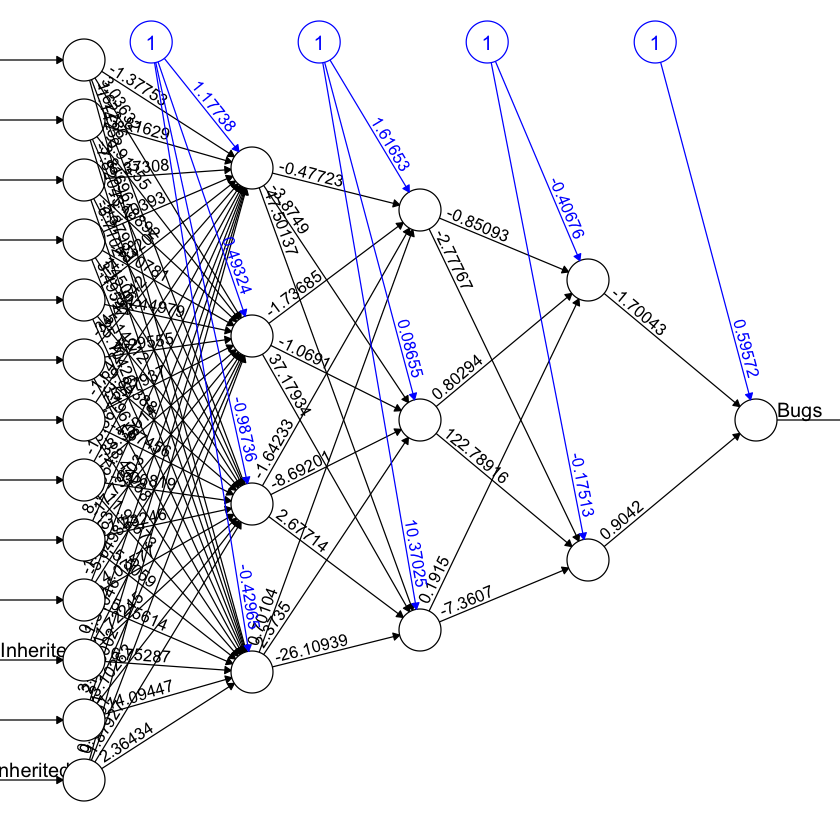

In [19]:
plot(nnetModel2, rep="best")

In [22]:
nnetModel2Stats <- evaluateStats(nnetModel2)
nnetModel2Stats

$RMSE
[1] 0.888

$rSquare
[1] -0.035

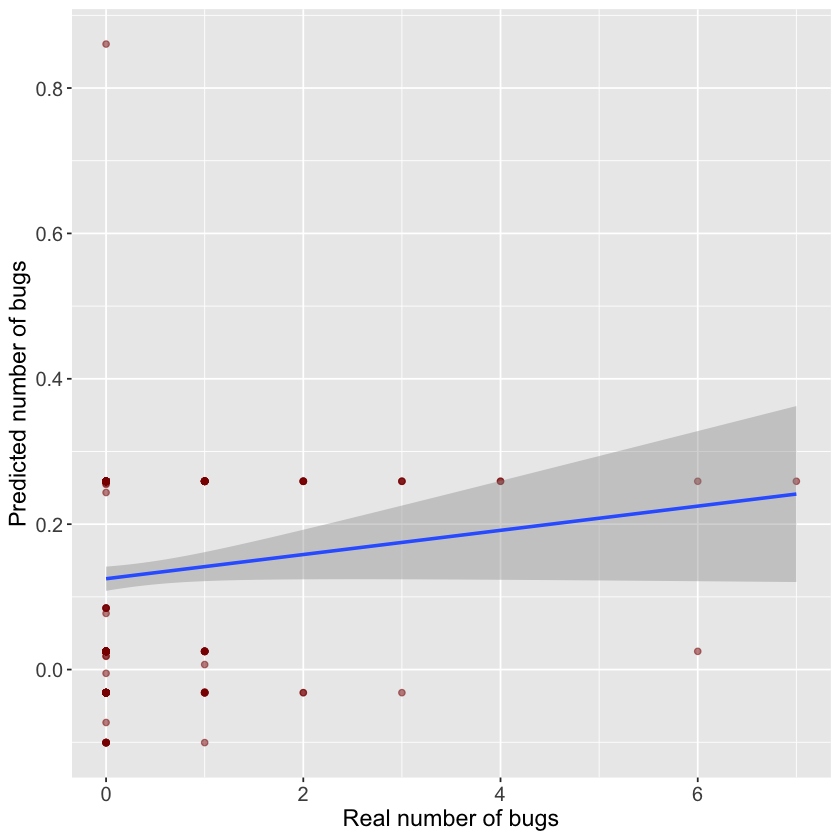

In [25]:
predictionChart(nnetModel2)

ERROR: Error in UseMethod("varImp"): niestosowalna metoda dla 'varImp' zastosowana do obiektu klasy "nn"


To be continued... Just some experiments.

# TODO Compare different regression models

In [21]:
compareDf <- data.frame(t(data.frame(
    knn = unlist(knnStats),
    knnPre = unlist(knnPreStats),
    rf = unlist(rfStats),
    xgb = unlist(xgbStats),
    xgbPre = unlist(xgbPreStats),
    nnetCaret = unlist(nnetModelStats),
    nnetNeuralnet = unlist(nnetModel2Stats)
)))
compareDf

ERROR: Error in unlist(knnStats): nie znaleziono obiektu 'knnStats'


To be continued...